<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/AI/FFT000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
import os
from tensorflow.python.client import device_lib
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])
print()
print()
from google.colab import files
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.layers import Layer
import matplotlib.gridspec as gridspec
from keras.models import Sequential
from keras.layers import Dense, Dropout,concatenate,Subtract,Multiply,Average, Concatenate,Reshape, Add, BatchNormalization
from keras.layers import Reshape,Lambda
from keras.layers.core import Activation
from keras.optimizers import SGD, Adam
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D,MaxPooling2D
import keras.losses
from keras.layers.core import Flatten
from keras import backend as K
import numpy as np
import scipy
from PIL import Image
from keras.layers import Input
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
noises = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TIPE
Utilise le CPU




Using TensorFlow backend.


In [0]:
# Install latest Tensorflow build
# !pip install -q tf-nightly-2.0-preview
# from tensorflow import summary
# %load_ext notebookµ

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [5]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy /= np.max(imageSortieTensorCopy)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
index = np.arange(0,len(images))
np.random.shuffle(index)
trainingData = [images[i] for i in index[:int(0.6*len(images))]]
evalData = [images[i] for i in index[int(0.6*len(images))-1:]]

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

In [17]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

W0819 15:17:09.521109 139698445698944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# cf https://stackoverflow.com/questions/43784921/how-to-display-custom-images-in-tensorboard-using-keras?noredirect=1#comment85726690_43784921
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    height, width = tensor.shape
    image = Image.fromarray(tensor).convert('RGB')
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    CHANNEL = 1
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=CHANNEL,
                         encoded_image_string=image_string)

In [0]:

def AI_gen_disc_or_disc_without_input(inpt,gen=False):
    print("Construction générateur discriminateur" if gen == True else "Construction discriminateur")
    global Llayers
    global index_couches
    if gen == True:
        with K.name_scope('Generateur'):
            couche = Dense(100,name=str(index_couches)+'_'+'dense_n100')(inpt)
            index_couches += 1
            couche = Dropout(name=str(index_couches)+'_'+'dropout',rate=0.25)(couche)
            index_couches += 1
            couche = LRN2D(name=str(index_couches)+'_'+'batchnorm',n=21,k=2,alpha=10**-4,beta=0.75)(couche)
            index_couches += 1
            couche = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(couche)
            index_couches += 1
            Llayers.append([couche,str(index_couches)+'_'+'activation_SELU'])
            couche = Dense(10,name=str(index_couches)+'_'+'dense_n10')(couche)
            index_couches += 1
            couche = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(couche)
            index_couches += 1
            couche = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(couche)
            index_couches += 1
            Llayers.append([couche,str(index_couches)+'_'+'activation_SELU'])
            couche = Dense(3,name=str(index_couches)+'_'+'dense_n3')(couche)
            index_couches += 1
            couche = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(couche)   
            index_couches += 1
            couche = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(couche)
            index_couches += 1
            Llayers.append([couche,str(index_couches)+'_'+'activation_SELU'])

    with K.name_scope('Discriminateur'):
        with K.name_scope('Bruit'):
            if gen == True:
                bruit = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f1_k2')(couche)
            else:
                bruit = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f1_k2')(inpt)
            index_couches += 1
            bruit = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(bruit)
            index_couches += 1
            bruit = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(bruit)
            index_couches += 1
            bruit = Convolution2D(filters=3,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f3_k2')(bruit)
            index_couches += 1
            bruit = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(bruit)
            index_couches += 1
            bruit = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(bruit)
            index_couches += 1
            if gen == True:
                bruit = Subtract(name=str(index_couches)+'_'+'subtract')([couche,bruit])
            else:
                bruit = Subtract(name=str(index_couches)+'_'+'subtract')([inpt,bruit])
            index_couches += 1
            Llayers.append([bruit,str(index_couches)+'_'+'subtract'])
            bruit = MaxPooling2D(name=str(index_couches)+'_'+'maxpooling',pool_size=3,padding='VALID')(bruit)
            index_couches += 1
            bruit1 = Convolution2D(filters=1,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f1_k2')(bruit)
            index_couches += 1
            bruit1 = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(bruit)
            index_couches += 1
            bruit1 = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(bruit)
            index_couches += 1
            bruit1 = Convolution2D(filters=3,kernel_size=(2,2),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f_k2')(bruit)
            index_couches += 1
            bruit1 = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(bruit)
            index_couches += 1
            bruit1 = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(bruit)
            index_couches += 1
            bruit = Subtract(name=str(index_couches)+'_'+'subtract')([bruit,bruit1])
            index_couches += 1
            Llayers.append([bruit,str(index_couches)+'_'+'subtract'])
            bruit = MaxPooling2D(name=str(index_couches)+'_'+'maxpooling',pool_size=3,padding='VALID')(bruit)
            index_couches += 1
            Llayers.append([bruit,'disc_bruit_3'])
            
        with K.name_scope('Traitement_image'):
    
            def inception(prevShapes):
                import time
                global index_couches
                inpt = Input(shape = prevShapes,name=str(index_couches)+'_'+'inception_input')
                index_couches += 1
                coucheT0 = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k1')(inpt)
                index_couches += 1
                coucheT1 = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k1')(inpt)
                index_couches += 1
                coucheT1 = Convolution2D(filters=100,kernel_size=(1,3),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k1_3')(coucheT1)
                index_couches += 1
                coucheT1 = Convolution2D(filters=100,kernel_size=(3,1),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k3_1')(coucheT1)
                index_couches += 1

                couche = Concatenate(axis=-1,name=str(index_couches)+'_'+'concatenate')([coucheT0,coucheT1])
                index_couches += 1
                couche = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k1')(couche)
                index_couches += 1
                couche = Add(name=str(index_couches)+'_'+'add')([couche,inpt])  
                return Model(input=inpt,output=couche,name=str(index_couches)+'_'+'Inception_%f'%(time.time()))
            
            if gen == True:
                coucheAdaptation = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k1')(couche)
            else:
                coucheAdaptation = Convolution2D(filters=100,kernel_size=(1,1),activation=None,strides=(1,1),padding='SAME',name=str(index_couches)+'_'+'Conv_f100_k1')(inpt)
            index_couches += 1
            inceptionModel = inception(coucheAdaptation.get_shape().as_list()[1:])
            index_couches += 1
            image = inceptionModel(coucheAdaptation)
            index_couches += 1
            image = LRN2D(name=str(index_couches)+'_'+'local_response_normalizer',n=21,k=2,alpha=10**-4,beta=0.75)(image)
            index_couches += 1
            image = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(image)
            index_couches += 1
            image = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(image)
            index_couches += 1
            Llayers.append([image,str(index_couches)+'_'+'activation_SELU'])
            index_couches += 1
            image = MaxPooling2D(name=str(index_couches)+'_'+'maxpooling',pool_size=3,padding='VALID')(image)
            index_couches += 1
            inceptionModel = inception(image.get_shape().as_list()[1:])
            index_couches += 1
            image = inceptionModel(image)
            index_couches += 1
            image = LRN2D(name=str(index_couches)+'_'+'local_response_normalizer',n=21,k=2,alpha=10**-4,beta=0.75)(image)
            index_couches += 1
            image = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(image)
            index_couches += 1
            image = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(image)
            index_couches += 1
            Llayers.append([image,str(index_couches)+'_'+'activation_SELU'])
            index_couches += 1
            image = MaxPooling2D(name=str(index_couches)+'_'+'maxpooling',pool_size=3,padding='VALID')(image)
            index_couches += 1
            inceptionModel = inception(image.get_shape().as_list()[1:])
            index_couches += 1
            image = inceptionModel(image)
            index_couches += 1
            image = LRN2D(name=str(index_couches)+'_'+'local_response_normalizer',n=21,k=2,alpha=10**-4,beta=0.75)(image)
            index_couches += 1
            image = BatchNormalization(name=str(index_couches)+'_'+'batchnorm')(image)
            index_couches += 1
            image = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(image)
            index_couches += 1
            Llayers.append([image,str(index_couches)+'_'+'activation_SELU'])
            index_couches += 1
    
        resultatAnalyse = Concatenate(axis=-1,name=str(index_couches)+'_'+'concatenate')([bruit,image])
        index_couches += 1
        resultatAnalyse = Flatten(name=str(index_couches)+'_'+'flatten')(resultatAnalyse)
        index_couches += 1
        resultatAnalyse = Dense(500,name=str(index_couches)+'_'+'dense_n500')(resultatAnalyse)
        index_couches += 1
        resultatAnalyse = Dropout(rate=0.25,name=str(index_couches)+'_'+'dropout')(resultatAnalyse)
        index_couches += 1
        resultatAnalyse = Activation(SELU,name=str(index_couches)+'_'+'activation_SELU')(resultatAnalyse)
        index_couches += 1
        probabilite = Dense(1,name=str(index_couches)+'_'+'dense_n1')(resultatAnalyse)
        index_couches += 1
        probabilite = Activation('sigmoid',name=str(index_couches)+'_'+'activation_sigmoid')(probabilite)
    return probabilite

In [0]:
def AI():
    inpt = Input(shape = (199, 199, 3),name=str(0)+'_'+'Image')
    probabilite_gen_disc = AI_gen_disc_or_disc_without_input(inpt,gen=True)
    probabilite_disc = AI_gen_disc_or_disc_without_input(inpt,gen=False)
    return Model(input=inpt,output=probabilite_gen_disc),Model(input=inpt,output=probabilite_disc)

In [0]:
def mean_gen_disc_top_9(disc,gen_disc,x,indexModele):
    disc_orig_backup = "Modele"+str(indexModele)+"_global_disc_orig.h5"
    disc_gen_orig_backup = "Modele"+str(indexModele)+"_global_gen_disc_orig.h5"
    # On commence par faire 3 essais avec le gen_disc
    Lloss_gen_disc = []
    Lloss_tot = []
    disc.save_weights(disc_orig_backup)
    gen_disc.save_weights(disc_gen_orig_backup)
    y = [1]*x.shape[0]
    for i in range(3):
        try:
            gen_disc.load_weights(disc_gen_orig_backup)
        except:
            gen_disc.load_weights(disc_gen_orig_backup)
        loss = gen_disc.train_on_batch(x,y)
        gen_disc_backup = "Modele"+str(indexModele)+"_global_gen_disc_%i.h5"%(i)
        try:
            gen_disc.save_weights(gen_disc_backup)
        except:
            gen_disc.save_weights(gen_disc_backup)
        Lloss_gen_disc.append([loss,gen_disc_backup])
    y = [1]*(x.shape[0]//2)+[0]*(x.shape[0]//2)
    for index_gen_disc,loss_pathBackup in enumerate(Lloss_gen_disc):
        for i in range(3):
            print("loss_pathBackup[1]",loss_pathBackup[1])
            try:
                gen_disc.load_weights(loss_pathBackup[1])
            except:
                gen_disc.load_weights(loss_pathBackup[1])
            loss = disc.train_on_batch(x,y)
            disc_backup = "Modele"+str(indexModele)+"_global_disc_branche_%i_essai_%i.h5"%(index_gen_disc,i)
            try:
                disc.save_weights(disc_backup)
            except:
                disc.save_weights(disc_backup)
            Lloss_tot.append([loss_pathBackup[0],loss_pathBackup[1],loss,disc_backup,np.mean([loss_pathBackup[0],loss])])
    Lloss_tot.sort(key=lambda elem:elem[-1])
    try:
        gen_disc.load_weights(Lloss_tot[0][1])
        disc.load_weights(Lloss_tot[0][-2])
    except:
        gen_disc.load_weights(Lloss_tot[0][1])
        disc.load_weights(Lloss_tot[0][-2])
        
    print("Resultat top 9 : ",Lloss_tot)
    return Lloss_tot[0]

In [0]:
def sauvegardeModele(entree_pure,entree_deterioree,model,iteration_entrainement,summary_writer,batch_size=7):
    global Llayers
    for canal_image in range(3):
        summary_image = tf.Summary(value=[tf.Summary.Value(tag="input_pure", 
                                image=make_image(entree_pure[0,:,:,canal_image]*255))])
        summary_writer.add_summary(summary_image,iteration_entrainement)
        summary_image = tf.Summary(value=[tf.Summary.Value(tag="input_deterioree", 
                                image=make_image(entree_deterioree[0,:,:,canal_image]*255))])
        summary_writer.add_summary(summary_image,iteration_entrainement)
        
    for p,entree in enumerate([entree_pure,entree_deterioree]):
        layer_outputs,layer_names = [Llayers[i][0] for i in range(len(Llayers))],[Llayers[i][1] for i in range(len(Llayers))]
        print("layer_outputs : ",layer_outputs)
        model_calcul_image = Model(input=model.input,outputs=[model.output]+layer_outputs)
        sorties_couches = model_calcul_image.predict(entree, batch_size=batch_size)[1:]
        for index_couche,sortie_couche in enumerate(sorties_couches):
            layer_name = layer_names[index_couche]
            dim_sortie = sortie_couche.shape
            if len(dim_sortie) == 4:
                for canal_image in range(dim_sortie[-1]):
                    tag = layer_name
                    tag += 'pure' if p == 0 else 'deterioree'
                    summary_image = tf.Summary(value=[tf.Summary.Value(tag=tag, 
                                            image=make_image(sortie_couche[0,:,:,canal_image]*255))])
                    summary_writer.add_summary(summary_image,iteration_entrainement)
    return None

In [0]:
from google.colab import output
def beep():
    output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
    return None

In [0]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
continuer = None
def block_or_continue():
    beep()
    print("Would you resume training ? True or False ?")
    return bool(input())

In [0]:
def backup(image,imageBruitee,gen_disc,disc,index,summary_writer):
    x = np.concatenate((image,imageBruitee))
    sauvegardeModele(image,imageBruitee,gen_disc,index,summary_writer)
    p_gen_disc = gen_disc.predict(x)[0]
    p_disc = disc.predict(x)[0]

    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité gen-disc img 0 (orig pure) pure : ", 
                                        simple_value=p_gen_disc) ])
    summary_writer.add_summary(summary_loss,index)
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité disc img 0 (orig pure) pure : ", 
                                        simple_value=p_disc) ])
    summary_writer.add_summary(summary_loss,index)
    x_proba = np.concatenate((imageBruitee,imageBruitee))
    p_gen_disc = gen_disc.predict(x_proba)[0]
    p_disc = disc.predict(x_proba)[0]
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité gen-disc img 0 (orig détériorée) pure : ", 
                                        simple_value=p_gen_disc) ])
    summary_writer.add_summary(summary_loss,index)
    summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Probabilité disc img 0 (orig détériorée) pure : ", 
                                        simple_value=p_disc) ])
    summary_writer.add_summary(summary_loss,index)

In [0]:
index_couches = 0
Llayers = []
def train_gen_disc(images,eval_data,indexModele):
    gen_disc,disc = AI()
    gen_disc_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    disc.compile(loss='binary_crossentropy', optimizer=disc_optim)
    gen_disc.compile(loss='binary_crossentropy', optimizer=gen_disc_optim)
    print("Layers : ",Llayers)
    print(gen_disc.summary())
    print(disc.summary())
    print(Llayers)
    Lloss = []
    iterations = 50
    index = 0
    import datetime
    chaine_date = datetime.datetime.today().strftime('%Y-%m-%d_%Hh%Mmin%Ss') #cf http://strftime.org/ et https://www.science-emergence.com/Articles/Obtenir-la-date-daujourdhui-au-format-YYYY-MM-DD-avec-python/
    summary_writer = tf.summary.FileWriter(logdir='./logs/Modele'+str(indexModele)+'_gen_disc_'+chaine_date,graph=tf.get_default_graph())
    while index < iterations:
        image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
        current_learning_rate = tauxApprentissage(index,10**-4,10,10**-7)
        K.set_value(disc.optimizer.lr, current_learning_rate)
        K.set_value(gen_disc.optimizer.lr, current_learning_rate)
        x = np.concatenate((image,imageBruitee))
        loss = mean_gen_disc_top_9(disc,gen_disc,x,indexModele)
        Lloss.append(loss)
        print("Iteration %i : gen_disc, erreur : %f ; disc, erreur : %f ; erreur moyenne : %f"%(index,loss[0],loss[2],loss[-1]))
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur gen-disc : binary-crossentropy", 
                                             simple_value=loss[0]) ])
        summary_writer.add_summary(summary_loss,index)
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur disc : binary-crossentropy", 
                                             simple_value=loss[2]) ])
        summary_writer.add_summary(summary_loss,index)
        summary_loss = tf.Summary(value=[tf.Summary.Value(tag="Erreur moyenne : binary-crossentropy", 
                                             simple_value=loss[-1]) ])
        summary_writer.add_summary(summary_loss,index)
        
        if index % 5 == 0:
            backup(image,imageBruitee,gen_disc,disc,index,summary_writer)
# #             summary_writer.close()
#             if index % 20 == 0:
#                 images_saved = block_or_continue()
#                 while images_saved != True:
#                     backup()
# #                     summary_writer.close()
#                     images_saved = block_or_continue()
# #                     summary_writer.reopen()
        index += 1
    summary_writer.close()
Lloss = train_gen_disc(images,evalData,7)

Construction générateur discriminateur


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="34_Inception_1565555178.301308", inputs=Tensor("Di..., outputs=Tensor("Di...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="48_Inception_1565555178.482421", inputs=Tensor("Di..., outputs=Tensor("Di...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="62_Inception_1565555178.668906", inputs=Tensor("Di..., outputs=Tensor("Di...)`


Construction discriminateur


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="98_Inception_1565555179.381723", inputs=Tensor("Di..., outputs=Tensor("Di...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="112_Inception_1565555179.794328", inputs=Tensor("Di..., outputs=Tensor("Di...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="126_Inception_1565555179.974751", inputs=Tensor("Di..., outputs=Tensor("Di...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("0_..., outputs=Tensor("Di...)`
  """


Layers :  [[<tf.Tensor 'Generateur_1/3_activation_SELU/mul_1:0' shape=(?, 199, 199, 100) dtype=float32>, '4_activation_SELU'], [<tf.Tensor 'Generateur_1/6_activation_SELU/mul_1:0' shape=(?, 199, 199, 10) dtype=float32>, '7_activation_SELU'], [<tf.Tensor 'Generateur_1/9_activation_SELU/mul_1:0' shape=(?, 199, 199, 3) dtype=float32>, '10_activation_SELU'], [<tf.Tensor 'Discriminateur_2/Bruit/16_subtract/sub:0' shape=(?, 199, 199, 3) dtype=float32>, '17_subtract'], [<tf.Tensor 'Discriminateur_2/Bruit/24_subtract/sub:0' shape=(?, 66, 66, 3) dtype=float32>, '25_subtract'], [<tf.Tensor 'Discriminateur_2/Bruit/25_maxpooling/MaxPool:0' shape=(?, 22, 22, 3) dtype=float32>, 'disc_bruit_3'], [<tf.Tensor 'Discriminateur_2/Traitement_image/38_activation_SELU/mul_1:0' shape=(?, 199, 199, 100) dtype=float32>, '39_activation_SELU'], [<tf.Tensor 'Discriminateur_2/Traitement_image/52_activation_SELU/mul_1:0' shape=(?, 66, 66, 100) dtype=float32>, '53_activation_SELU'], [<tf.Tensor 'Discriminateur_2/Trai

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("0_...)`
  


layer_outputs :  [<tf.Tensor 'Generateur_1/3_activation_SELU/mul_1:0' shape=(?, 199, 199, 100) dtype=float32>, <tf.Tensor 'Generateur_1/6_activation_SELU/mul_1:0' shape=(?, 199, 199, 10) dtype=float32>, <tf.Tensor 'Generateur_1/9_activation_SELU/mul_1:0' shape=(?, 199, 199, 3) dtype=float32>, <tf.Tensor 'Discriminateur_2/Bruit/16_subtract/sub:0' shape=(?, 199, 199, 3) dtype=float32>, <tf.Tensor 'Discriminateur_2/Bruit/24_subtract/sub:0' shape=(?, 66, 66, 3) dtype=float32>, <tf.Tensor 'Discriminateur_2/Bruit/25_maxpooling/MaxPool:0' shape=(?, 22, 22, 3) dtype=float32>, <tf.Tensor 'Discriminateur_2/Traitement_image/38_activation_SELU/mul_1:0' shape=(?, 199, 199, 100) dtype=float32>, <tf.Tensor 'Discriminateur_2/Traitement_image/52_activation_SELU/mul_1:0' shape=(?, 66, 66, 100) dtype=float32>, <tf.Tensor 'Discriminateur_2/Traitement_image/66_activation_SELU/mul_1:0' shape=(?, 22, 22, 100) dtype=float32>, <tf.Tensor 'Discriminateur_3/Bruit/80_subtract/sub:0' shape=(?, 199, 199, 3) dtype=f

## FFT

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
W0819 15:17:34.555299 139698445698944 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0819 15:17:34.590453 139698445698944 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: ignored

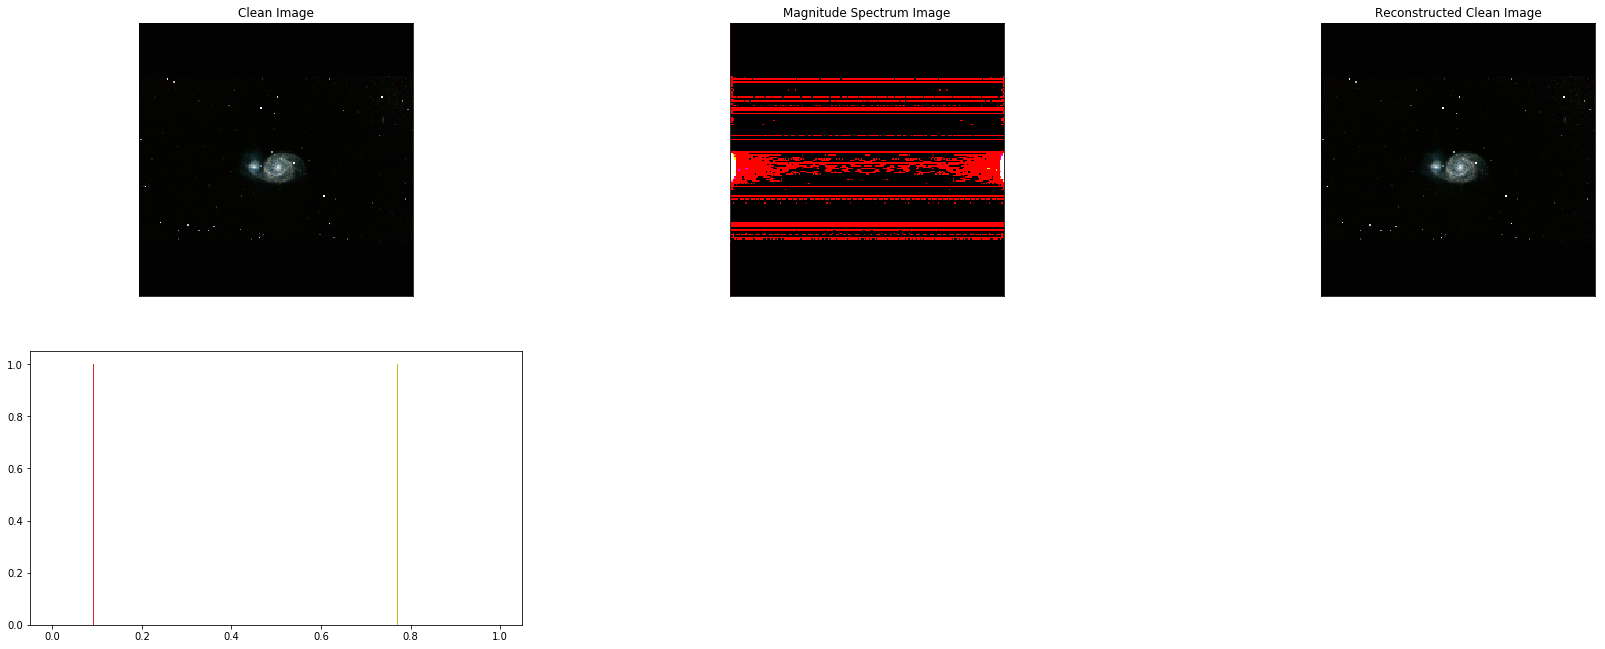

In [27]:
num_samples = 5
plt.figure(figsize=(30,30*num_samples))
for i in range(num_samples):
    image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
    image,imageBruitee = image[0,:,:,:],imageBruitee[0,:,:,:]

    import cv2
    import numpy as np
    from matplotlib import pyplot as plt

    image_fft = np.fft.fft2(image)
    imageBruitee_fft = np.fft.fft2(imageBruitee)
    image_shift = image_fft
    imageBruitee_shift = imageBruitee_fft
    # image_shift = np.fft.fftshift(image_fft)
    # imageBruitee_shift = np.fft.fftshift(imageBruitee_fft)
    image_magnitude_spectrum = 20*np.log(np.abs(image_shift))
    imageBruitee_magnitude_spectrum = 20*np.log(np.abs(imageBruitee_shift))

    def hist(img_array):
        return np.concatenate((plt.hist(image_magnitude_spectrum[:,:,0],256,[0,1]),plt.hist(image_magnitude_spectrum[:,:,1],256,[0,1]),plt.hist(image_magnitude_spectrum[:,:,2],256,[0,1])))
    
    image_back = np.abs(np.fft.ifft2(image_shift))
    imageBruitee_back = np.abs(np.fft.ifft2(imageBruitee_shift))
    n_ligne = 5*num_samples
    tot_group_index = 3*3
    plt.subplot(n_ligne,3,i*tot_group_index+1),plt.imshow(image)
    plt.title('Clean Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+2),plt.imshow(image_magnitude_spectrum)
    plt.title('Magnitude Spectrum Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+3),plt.imshow(image_back)
    plt.title('Reconstructed Clean Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+4),plt.imshow(hist(image))
    plt.title('Histogram Clean Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+5),plt.imshow(hist(image_magnitude_spectrum))
    plt.title('Histogram Spectrum Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+6),plt.imshow(hist(image_back))
    plt.title('Histogram Reconstructed Clean Image'), plt.xticks([]), plt.yticks([])


    plt.subplot(n_ligne,3,i*tot_group_index+7),plt.imshow(imageBruitee)
    plt.title('Noise Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+8),plt.imshow(imageBruitee_magnitude_spectrum)
    plt.title('Magnitude Spectrum Noise'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+9),plt.imshow(imageBruitee_back)
    plt.title('Reconstructed Noise Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+10),plt.imshow(hist(imageBruitee))
    plt.title('Histogram Noise Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+11),plt.imshow(hist(imageBruitee_magnitude_spectrum))
    plt.title('Histogram Spectrum Noise Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(n_ligne,3,i*tot_group_index+12),plt.imshow(hist(imageBruitee_back))
    plt.title('Histogram Reconstructed Noise Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(n_ligne,3,i*tot_group_index+13),plt.imshow(np.abs(image-imageBruitee))
    plt.subplot(n_ligne,3,i*tot_group_index+14),plt.imshow(np.abs(image_magnitude_spectrum-imageBruitee_magnitude_spectrum))
    plt.subplot(n_ligne,3,i*tot_group_index+15),plt.imshow(np.abs(image_back-imageBruitee_back))
plt.show()